This file contains code to explore and import training data from an athlete's Strava export.

There are instructions on how to export your own data from Strava in the project Docusaurus site [here](https://redback-operations.github.io/redback-documentation/docs/project-3/research/strava-bulk-export-data-description).

# 1. General data exploration

In [1]:
import pandas as pd
activities_df = pd.read_csv('data/strava_activities-TRI001.csv')

# Count the number of activities for each Activity Type
activity_counts = activities_df['Activity Type'].value_counts()
activity_counts

Run                1553
Ride                487
Swim                223
Virtual Ride         46
Weight Training      31
Workout               8
Walk                  3
Name: Activity Type, dtype: int64

In [2]:
# Look at how many rides have recorded Average Watts and Average Heart Rate

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Average Watts'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_94116/950879621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


237

In [3]:
# Look at how many rides have recorded Weighted *Average* Watts and Average Heart Rate
# We do this because Strava will fill in 'Average Watts' even on rides where power data is missing

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Weighted Average Power'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_94116/4091331926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


181

In [4]:
# Look at how many runs have recorded Average Watts and Average Heart Rate

# Filter for 'Run' activities
run_activities = activities_df[activities_df['Activity Type'] == 'Run']

# Filter for runs with recorded Average Watts and Average Heart Rate
filtered_runs = run_activities[(run_activities['Weighted Average Power'].notna()) & 
                               (run_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_run_count = len(filtered_runs)
filtered_run_count


167

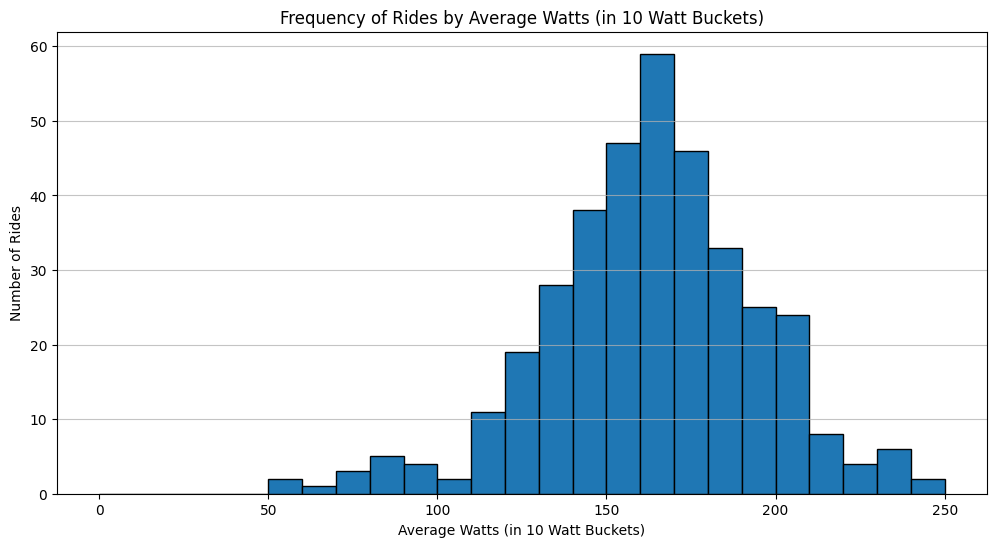

In [5]:
# View the power ranges in the summary file

import matplotlib.pyplot as plt
import numpy as np

# Dropping NaN values from 'Average Watts' for plotting
ride_watts = ride_activities['Weighted Average Power'].dropna()

# Creating a histogram
plt.figure(figsize=(12, 6))
plt.hist(ride_watts, bins=np.arange(0, ride_watts.max() + 10, 10), edgecolor='black')
plt.title('Frequency of Rides by Average Watts (in 10 Watt Buckets)')
plt.xlabel('Average Watts (in 10 Watt Buckets)')
plt.ylabel('Number of Rides')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [6]:
import csv
import gzip
from fitparse import FitFile

def fit_gz_to_csv(fit_gz_file_path, csv_file_path):
    # Decompress the .fit.gz file and parse it
    with gzip.open(fit_gz_file_path, 'rb') as f:
        fitfile = FitFile(f)

        # Collect all unique field names from all records
        field_names = set()
        for record in fitfile.get_messages('record'):
            field_names.update(record.get_values().keys())

        # Sort field names for consistent column ordering
        field_names = sorted(field_names)

        # Open or create the CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            # Write data for each record
            for record in fitfile.get_messages('record'):
                data = record.get_values()
                writer.writerow(data)


In [5]:
import csv
import gzip
from fitparse import FitFile

def fit_gz_to_csv_gz(fit_gz_file_path, csv_file_path):
    # Decompress the .fit.gz file and parse it
    with gzip.open(fit_gz_file_path, 'rb') as f:
        fitfile = FitFile(f)

        # Collect all unique field names from all records
        field_names = set()
        for record in fitfile.get_messages('record'):
            field_names.update(record.get_values().keys())

        # Sort field names for consistent column ordering
        field_names = sorted(field_names)

        # Open or create the CSV file
        with gzip.open(csv_file_path, mode='wt', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            # Write data for each record
            for record in fitfile.get_messages('record'):
                data = record.get_values()
                writer.writerow(data)

In [97]:
fit_gz_to_csv('../../../../activities/3139195577.fit.gz', 'data/3139195577.csv')
fit_gz_to_csv_gz('data/3117764808.fit.gz', 'data/3117764808.csv.gz')

In [11]:
import pandas as pd

csv_file_path = 'data/activities/3139195577.csv.gz'
ride_data_df = pd.read_csv(csv_file_path, compression='gzip')

# Calculate average power and average heart rate
average_power = ride_data_df['power'].mean()
average_heart_rate = ride_data_df['heart_rate'].mean()

average_power, average_heart_rate


(104.24955181068484, 112.8131946934385)

In [12]:
# Exclude power readings when the bike is stationary (assuming power is zero when stationary)
active_power_readings = ride_data_df[ride_data_df['power'] > 0]

# Calculate the average power excluding stationary periods
average_active_power = active_power_readings['power'].mean()
average_active_power


123.06962962962963

In [8]:
def format_duration(seconds):
    if seconds < 60:
        return f"{seconds}s"
    elif seconds < 3600:
        return f"{seconds / 60:.1f}min"
    else:
        return f"{seconds / 3600:.1f} hr"

In [53]:
def max_value(data, max_durations, field):
    max_values = {duration: 0 for duration in max_durations}
    value_sum = {duration: 0 for duration in max_durations}
    value_queue = {duration: [] for duration in max_durations}

    if field in data.columns:

        for value in data[field]:

            # Convert blank value to zero
            if pd.isna(value) | (value == ''):
                value = 0
            else:
                # Ensure value is a number
                value = float(value)

            for duration in max_durations:
                # Add current value to the queue and sum for each duration
                value_queue[duration].append(value)
                value_sum[duration] += value

                # If the queue length exceeds the duration, subtract the oldest value and remove it from the queue
                if len(value_queue[duration]) > duration:
                    value_sum[duration] -= value_queue[duration].pop(0)

                # Update the maximum value if the current average is higher
                if len(value_queue[duration]) == duration:
                    avg_value = value_sum[duration] / duration
                    max_values[duration] = max(max_values[duration], avg_value)

    # Convert the dictionary of max values into a list of pairs (duration, max value)
    max_value_pairs = [(duration, value) for duration, value in max_values.items()]
    return max_value_pairs


In [15]:
# Durations in seconds for which to calculate max power
durations = [5, 10, 30, 60, 5*60, 10*60, 20*60, 30*60, 60*60, 90*60, 120*60]  # 5s, 10s, 30s, 60s, and 5min

# Calculate max power for each duration
power_curve = max_value(ride_data_df, durations, 'power')
power_curve

[(5, 422.6),
 (10, 390.5),
 (30, 265.1),
 (60, 213.28333333333333),
 (300, 146.15),
 (600, 135.14333333333335),
 (1200, 127.45416666666667),
 (1800, 125.48333333333333),
 (3600, 110.17805555555556),
 (5400, 104.71259259259259),
 (7200, 0)]

In [16]:
# Filter out tuples where the power value is 0 and format durations
filtered_durations = []
filtered_powers = []

for duration, power in power_curve:
    if power > 0:
        filtered_durations.append(format_duration(duration))
        filtered_powers.append(power)
        print(f"Duration: {format_duration(duration)}, Power: {round(power, 1)} Watts")


Duration: 5s, Power: 422.6 Watts
Duration: 10s, Power: 390.5 Watts
Duration: 30s, Power: 265.1 Watts
Duration: 1.0min, Power: 213.3 Watts
Duration: 5.0min, Power: 146.2 Watts
Duration: 10.0min, Power: 135.1 Watts
Duration: 20.0min, Power: 127.5 Watts
Duration: 30.0min, Power: 125.5 Watts
Duration: 1.0 hr, Power: 110.2 Watts
Duration: 1.5 hr, Power: 104.7 Watts


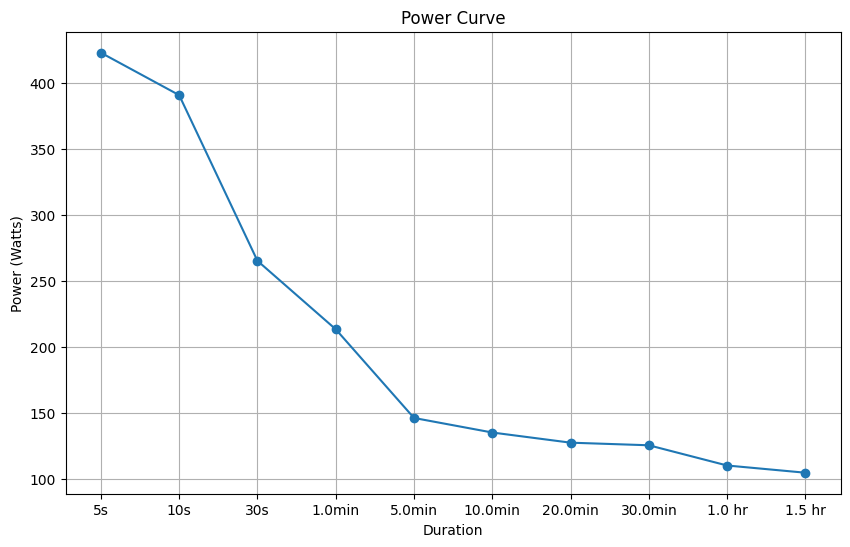

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(filtered_durations, filtered_powers, marker='o')
plt.xlabel('Duration')
plt.ylabel('Power (Watts)')
plt.title('Power Curve')
plt.grid(True)
plt.show()

# 2. Clean up the data file

## 2.1 Extract only the rides and runs that have power and heart rate information recorded.

In [64]:
import pandas as pd

source_path = '../../../Projects/Strava export/export_13076767/'
data_directory = 'data/'
athlete_id = 'TRI001'

# Reload the CSV file and check for empty fields
activities_df = pd.read_csv(source_path+'activities.csv')

In [65]:
# Select all the activities that are rides, virtual rides, runs, or swims
target_activities = activities_df[activities_df['Activity Type'].isin(['Ride', 'Virtual Ride', 'Run', 'Swim'])]

# Look at how many rides have recorded Weighted Average Watts and Average Heart Rate

# Convert 'Distance' to a numeric value for comparison
target_activities['Distance'] = pd.to_numeric(target_activities['Distance'], errors='coerce')

# Filter to include activities with recorded Weighted Average Power and Average Heart Rate or are swim sessions

# Filter for 'Swim' activities where Filename is not null

swim_sessions = target_activities[(target_activities['Activity Type'] == 'Swim')
                                  & (target_activities['Filename'].notnull())]
other_records = target_activities[(target_activities['Activity Type'] != 'Swim') & 
                                  (target_activities['Weighted Average Power'].notnull()) & 
                                  (target_activities['Average Heart Rate'].notnull())]

filtered_activities = pd.concat([swim_sessions, other_records])

# Filter out 'Run' activities with distance less than 2km, and rides with distance less than 10 km
filtered_activities = filtered_activities[((filtered_activities['Activity Type'] == 'Ride') & (filtered_activities['Distance'] >= 10)) | 
                                          ((filtered_activities['Activity Type'] == 'Run') & (filtered_activities['Distance'] >= 2)) |
                                          (filtered_activities['Activity Type'] == 'Swim')]


# Count the number of matching activities
filtered_activity_count = len(filtered_activities)
filtered_activity_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/1953030686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_activities['Distance'] = pd.to_numeric(target_activities['Distance'], errors='coerce')


561

In [66]:
# Remove columns that are empty for all entries
df_cleaned = filtered_activities.dropna(axis=1, how='all')

print(f'Strating field count: {len(filtered_activities.columns.tolist())}')
print(f'Ending field count: {len(df_cleaned.columns.tolist())}')
print(df_cleaned.columns.tolist())

# Save the cleaned DataFrame back to a new CSV file
df_cleaned.to_csv('data/activities_cleaned_'+athlete_id+'.csv', index=False)

Strating field count: 87
Ending field count: 47
['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Max Heart Rate.1', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Relative Effort.1', 'Total Work', 'Perceived Exertion', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1', 'From Upload', 'Grade Adjusted Distance', 'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Dirt Distance', 'Total Steps']


## 2.2 Add the maximum power values for different durations to allow the creation of a power curve for the athlete.

In [67]:
import pandas as pd
import gzip
import os
from fitparse import FitFile

df = df_cleaned

# Define the durations
durations = [5, 10, 30, 60, 5*60, 10*60, 20*60, 30*60, 60*60, 90*60, 120*60]


# Process each FIT file
for i, (index, row) in enumerate(df.iterrows()):
    print(f'Processing {row["Filename"]} ({i + 1} of {len(df)}).')
    fit_file_path = os.path.join(source_path, row['Filename'])
    csv_file_path = os.path.join(data_directory, row['Filename']).replace('.fit', '.csv')

    # Only create the csv if it does not already exist
    if not os.path.exists(csv_file_path):
        fit_gz_to_csv_gz(fit_file_path, csv_file_path)

    workout_data_df = pd.read_csv(csv_file_path, compression='gzip')

    # Calculate max pace for each duration if pace data is available
    max_paces = max_value(workout_data_df, durations, 'speed')
    
    # Update the DataFrame with the new max pace values
    for duration, pace in max_paces:
        col_name = f'Maximum Pace {format_duration(duration)}'
        df.at[index, col_name] = round(pace, 1)

    # Skip processing of power values for swimming activities
    if row['Activity Type'] == 'Swim':
        continue

    # Calculate max power for each duration if power data is available
    max_powers = max_value(workout_data_df, durations, 'power')

    # Update the DataFrame with the new max power values
    for duration, power in max_powers:
        col_name = f'Maximum Power {format_duration(duration)}'
        df.at[index, col_name] = round(power, 1)

# Clean the DataFrame by removing redundant columns

# Drop the columns 'Elapsed Time.1', 'Max Heart Rate.1', 'Relative Effort.1', 'Commute.1'
df = df.drop(columns=['Elapsed Time.1', 'Max Heart Rate.1', 'Relative Effort.1', 'Commute.1'])

# Rename 'Distance.1' to 'Distance' and drop the old 'Distance' column
df = df.drop(columns=['Distance']).rename(columns={'Distance.1': 'Distance'})

# Change '.fit.gz' to '.csv.gz' in the 'Filename' column
df['Filename'] = df['Filename'].str.replace('.fit.gz', '.csv.gz', regex=False)

# Save the updated DataFrame to a new CSV file
df.to_csv('data/extended_activities_'+athlete_id+'.csv', index=False)

Processing activities/2629768857.fit.gz (1 of 561).
Processing activities/3075198188.fit.gz (2 of 561).
Processing activities/3125230680.fit.gz (3 of 561).
Processing activities/3130017486.fit.gz (4 of 561).
Processing activities/3134662493.fit.gz (5 of 561).
Processing activities/3141859223.fit.gz (6 of 561).
Processing activities/3151848166.fit.gz (7 of 561).
Processing activities/3160818292.fit.gz (8 of 561).
Processing activities/3166621831.fit.gz (9 of 561).
Processing activities/3172486866.fit.gz (10 of 561).
Processing activities/3182721861.fit.gz (11 of 561).
Processing activities/3189136340.fit.gz (12 of 561).
Processing activities/3198455098.fit.gz (13 of 561).
Processing activities/3202025396.fit.gz (14 of 561).
Processing activities/3205896010.fit.gz (15 of 561).
Processing activities/3215106191.fit.gz (16 of 561).
Processing activities/3218617946.fit.gz (17 of 561).
Processing activities/3228504926.fit.gz (18 of 561).
Processing activities/3246770685.fit.gz (19 of 561).
Pr

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, col_name] = round(pace, 1)
/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, col_name] = round(pace, 1)
/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Processing activities/4545483177.fit.gz (43 of 561).
Processing activities/4554149716.fit.gz (44 of 561).
Processing activities/4575810536.fit.gz (45 of 561).
Processing activities/4586169784.fit.gz (46 of 561).
Processing activities/4613071954.fit.gz (47 of 561).
Processing activities/4623699163.fit.gz (48 of 561).
Processing activities/4648862644.fit.gz (49 of 561).
Processing activities/4658368589.fit.gz (50 of 561).
Processing activities/4683707123.fit.gz (51 of 561).
Processing activities/4694053925.fit.gz (52 of 561).
Processing activities/4717338364.fit.gz (53 of 561).
Processing activities/4726741239.fit.gz (54 of 561).
Processing activities/4749010741.fit.gz (55 of 561).
Processing activities/4758004757.fit.gz (56 of 561).
Processing activities/4780303325.fit.gz (57 of 561).
Processing activities/4788371887.fit.gz (58 of 561).
Processing activities/4810398722.fit.gz (59 of 561).
Processing activities/4818969935.fit.gz (60 of 561).
Processing activities/4863124625.fit.gz (61 of

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, col_name] = round(power, 1)
/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, col_name] = round(power, 1)
/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_25754/2991041979.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Processing activities/3139195577.fit.gz (219 of 561).
Processing activities/3144285271.fit.gz (220 of 561).
Processing activities/3148981215.fit.gz (221 of 561).
Processing activities/3154484363.fit.gz (222 of 561).
Processing activities/3163594852.fit.gz (223 of 561).
Processing activities/3169611218.fit.gz (224 of 561).
Processing activities/3175444403.fit.gz (225 of 561).
Processing activities/3179045206.fit.gz (226 of 561).
Processing activities/3185737014.fit.gz (227 of 561).
Processing activities/3221319414.fit.gz (228 of 561).
Processing activities/3224625345.fit.gz (229 of 561).
Processing activities/3231240844.fit.gz (230 of 561).
Processing activities/3234065852.fit.gz (231 of 561).
Processing activities/3240773289.fit.gz (232 of 561).
Processing activities/3243747987.fit.gz (233 of 561).
Processing activities/3250875085.fit.gz (234 of 561).
Processing activities/3257177281.fit.gz (235 of 561).
Processing activities/3269552122.fit.gz (236 of 561).
Processing activities/327683